## Семинарская часть

Сегодня мы будем работать с линейной регрессией в библиотеке sklearn. Воспользуемся классами с различным типом регуляризации и подберем оптимальные гипер-параметры для этих моделей. Решать будем задачу с Kaggle про предсказание длины поездки в такси [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview).

Данные уже скачаны.

Распакуем данные, которые мы загрузили. Работать будем только с train частью, так как там имеются значения предсказываемой переменной.

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.csv', header=0, sep=',', quotechar='"')

In [ ]:
df.head()

Мы видим информацию о каждой поездке. Нам известны координаты, время начала поездки, количество пассажиров и т.д. Удалим колонку, которая есть только в обучающей выборке `dropoff_datetime`. Из названия понятно, что используя эту колонку и `pickup_datetime` мы сможем восстановить длину поездки. Очевидно, что в начале поездки `dropoff_datetime` нам недоступна, а значит и для предсказания ее использовать нельзя.

In [ ]:
df = df.drop('dropoff_datetime', axis=1)

Сейчас даты записаны в виде строк. Давайте преобразуем их в питонячие datetime объекты. Таким образом мы сможем выполнять арифметические операции с датами и вытаскивать нужную информацию, не работая со строками.

In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Давайте разобьем выборку на train и test. Применить функцию `train_test_split` в этот раз не получиться. Мы теперь имеем дело с временными данными и на практике наша модель должна уметь работать во временных периодах, которых нет в обучающей выборке. Поэтому разбивать мы будем датасет по хронологии. Для этого отсортируем датасет по дате и возьмем первые N строк.

In [ ]:
df = df.sort_values(by='pickup_datetime')

In [ ]:
df.head()

In [ ]:
df_train = df[:500_000]
df_test = df[500_000:700_000]

Напомню, что мы будем пресказывать переменную trip_duration. Посмотрим на целевую переменную.

In [ ]:
df_train.trip_duration.hist(bins=100, grid=False, )

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые например мнгновенно завершились. 

In [ ]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [ ]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Посмотрим на наши признаки. Давайте нарисуем, как выглядит распределение количества поездок по дням.

In [ ]:
date_sorted = df_train.pickup_datetime.dt.date.sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

In [ ]:
sns.countplot(
  df_train.pickup_datetime.apply(lambda x: x.hour),
)

Теперь давайте посмотрим, как связан день и длина поездки.

In [ ]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.dt.date)
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');

Мы видим явный тренд. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

Теперь подготовим датасет. Включим в него день года и час дня. Для этого напишем функцию `create_features`, которая будет собирать нам нужные признаки в отдельный `pandas.DataFrame`. В итоге, мы сможем воспользоваться этой функцией, как для train подвыборки, так и для test.

In [ ]:
import datetime
def create_features(data_frame):
    X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day', 'hour',]
    )
  
    return X, data_frame.log_trip_duration

In [ ]:
X_train, y_train = create_features(df_train)

In [ ]:
X_test, y_test = create_features(df_test)

In [ ]:
X_train.head()

Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one -hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборке не встреться нам на тестовом подмножестве.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

In [ ]:
X_train = ohe.fit_transform(X_train)

In [ ]:
X_test = ohe.transform(X_test)

Воспользуемся классом `Ridge` и обучим модель.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [ ]:
mean_squared_error(ridge.predict(X_test), y_test)

### Задание 1
Постройте график соответствующий количеству поездок в зависимости от дня недели по обучающей выборке. Какой из этих графиков соответствует правильному?


1)
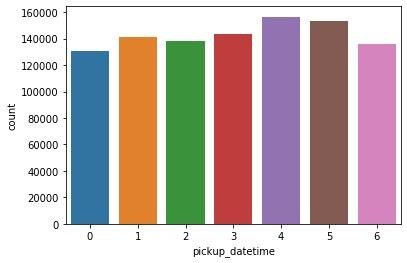

2)
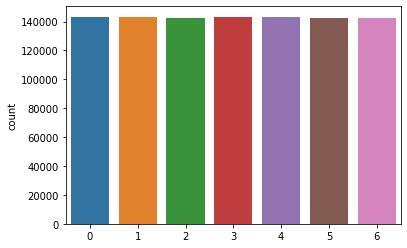

3)
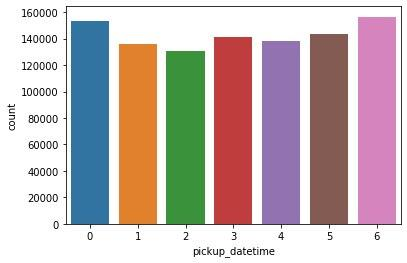

In [ ]:
correct_graph = ...

# your code here


In [ ]:
# проверка, просто запустите ячейку


### Задание 2

Добавьте к признакам one-hot переменную, которая равна 1 (или True) для двух аномальных дней и 0 (или False) во все остальные дни.
Для этого вам понадобиться модифицировать функцию create_features. 

Рекомендуется создавать новые датафреймы из стартовых для домашнего задания (то есть df_train и df_test). На выходе из функции вы должны получить dataframe с 3 признаками: ```day```, ```hour``` и ```anomaly```. Подсказка: сделать это можно всего за 3 применения .apply(). Иначе ваша функция может работать слишком долго.

In [ ]:
def create_features(data_frame):
    # your code
    return None, None
    
    
# your code here


In [ ]:
# %time измерит время выполнения вашей фукнции:
# При отправке удалите "%time"

%time new_X_train, new_y_train = create_features(df_train)

Обратите внимание: для успешной сдачи, wall time должен быть < 30 секунд.
Когда убедитесь, что фукнция работает достаточно быстро, **удалите %time**. 

Далее идет небольшая неоцениваемая проверка. Понимать код написанный там не нужно. Просто запустите ячейку. Если она запускается без ошибок - можете продолжать, иначе - следуйте в соответствии с выданной ошибкой (предварительно раскомментируйте)

In [ ]:
# Небольшая проверка: если ячейка выполнилась без ошибок, можете продолжать.

#assert 'new_X_train' in locals(), "Переменной new_X_train не существует. Проверьте названия."
#assert 'new_y_train' in locals(), "Переменной new_y_train не существует. Проверьте названия."
#assert type(new_X_train) == pd.core.frame.DataFrame, \
#                            "Переменная new_X_train должна быть типа pandas DataFrame"
#assert len(new_X_train) == 500_000, "Количество примеров должно остаться равным 500 000"
#assert all(new_X_train.columns.values == ['day', 'hour', 'anomaly']), \
#                            "Проверьте количество и названия колонок"
#assert all(new_X_train[new_X_train['day'] == 24]['anomaly'] == True), \
#                            "Значение признака anomaly для сэмплов 24.01 должно равняться True или 1"
#assert any(new_X_train[(new_X_train['day'] != 23) & (new_X_train['day'] != 24)]['anomaly']) == False, \
#                            "Значение признака anomaly для сэмплов не 23.01 и 24.01 должно равняться False или 0"

In [ ]:
# Если предыдущая ячейка не выдала ошибок, можно смело выполнять для теста:

new_X_test, new_y_test = create_features(df_test)

In [ ]:
# А теперь полноценная проверка переменных new_X_train, new_X_test
# Просто запустите ячейку


Чтобы не тратить время и мощности мы отрежем только 10000 примеров от обучающих данных. Здесь будет проверяться ответ именно для модели, обученной на первых 10000 примерах. Округлите значение **до 3 знаков** после запятой.

Вы можете выполнить данный ноутбук в локальном jupyter или где-то еще и обучить модель на всем наборе данных. Абсолютно весь код при этом будет таким же, но на время обучения модели может потребоваться некоторое время.

In [ ]:
# Ваш код для обучения Lasso регрессии с параметром alpha 2.65e-05 и подсчетом MSE:

MSE = ...


# your code here


In [ ]:
# Небольшая проверка для себя
import hashlib

assert hashlib.sha256(str(round(MSE, 3)).encode()).hexdigest() == '7a7aaf305bb9f734cf66fb258decc961e20739efac706ef440a4f5f2a2afd5b2'

In [ ]:
# проверка, просто запустите ячейку


In [ ]:
#Ваше решение


num_nonzero_features = ...


# your code here


In [ ]:
# Небольшая проверка для себя
import hashlib

assert hashlib.sha256(str(num_nonzero_features).encode()).hexdigest() == '3fdba35f04dc8c462986c992bcf875546257113072a909c162f7e470e581e278'